# Credit Card Customers_Building Model Pipeline

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline. 

The steps will: 

   - 1. Cleaning, EDA, and Visualization
   - 2. Feature Engineering and Feature Scaling
   - 3. Oversampling 
   - 4. Hyperparamer Tuning for Gradient Boosting Model
   - __5. Building Model Pipeline__
   
==========================================================================================

### Overview

In the previous notebooks, we explored data analysis, engineered features, scaled features, and used oversampled. 

In this notebook, I will compare the model performances of 6 different algorithms, and I will choose one of the best model. Also, I will build a machine learning pipeline for the best performance model. 

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from pathlib import Path
import os
os.getcwd()

'/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/CreditCard'

In [2]:
# set up path for data
path = Path('/Users/yejiseoung/Dropbox/My Mac (Yejis-MacBook-Pro.local)/Documents/Projects/CreditCard/Data/')

In [3]:
# Data pre-processing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate

# Modelling 
from sklearn.metrics import (
    roc_auc_score,
    precision_score, 
    accuracy_score, 
    recall_score,
)

from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier)

import xgboost as xgb

# for feature engineering
from feature_engine import encoding as ce

# Evaluation & CV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    RepeatedStratifiedKFold)


# pipeline
from sklearn.pipeline import Pipeline

# for oversampling
from imblearn.over_sampling import ADASYN, SMOTE

# since sklearn pipeline doesn't work well with oversampling 
# we need to use imblearn package's pipeline
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbPipeline

# for hyperparameter tuning
import optuna

### Load Data

In [4]:
df = pd.read_csv(path/'BankChurners.csv')

In [5]:
# drop unuseful columns 
df.drop(['CLIENTNUM',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis=1, inplace=True)

df.shape

(10127, 20)

In [6]:
df.head(2)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


In [7]:
# create lists for categorical and numerical variables
cat_vars = [var for var in df.columns if df[var].dtype=='O' and var != 'Attrition_Flag']
num_vars = [var for var in df.columns if df[var].dtype!='O']

print('The number of categorical variables: {}'.format(len(cat_vars)))
print('The number of numerical vairables: {}'.format(len(num_vars)))

The number of categorical variables: 5
The number of numerical vairables: 14


## Separate Dataset into train and test

It is important to separate the data into training and testing set, because when we engineer features, some techniques learn parameters from data. This is to avoid over-fitting.

In [8]:
df['Attrition_Flag'].value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [9]:
churn_map = {'Existing Customer': 0,
            'Attrited Customer': 1}
df['Attrition_Flag'] = df['Attrition_Flag'].map(churn_map)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Attrition_Flag'], axis=1),
    df['Attrition_Flag'],
    test_size=0.2, 
    random_state=0)

X_train.shape, X_test.shape

((8101, 19), (2026, 19))

## ML Comparison 

Here, I will compare 6 different machine learning algorithms based on the performances, and I will choose best 3 models later. 

Let's write machine learning pipeline. 

In [11]:
models = [
    ('LR', LogisticRegression(max_iter=1000)),
    ('SVC', SVC(kernel='rbf', C=0.025, probability=True)),
    ('KNN', KNeighborsClassifier(n_neighbors=2)),
    ('RF', RandomForestClassifier()),
    ('ADA', AdaBoostClassifier()),
    ('GBM', GradientBoostingClassifier())
]

In [12]:
# create a name list
fnames = []

for name, model in models:
    
    pipe = Pipeline([
        # Integer Encoding for Categorical Variable
        ('encoding', ce.OrdinalEncoder(
            encoding_method='arbitrary', variables=cat_vars)),

        # Feature Scaling
        ('scaler', StandardScaler()),
    

        # models
        ('classifier', model) 
    ])
    
    
    pipe.fit(X_train, y_train)
    
    pipe_prediction = pipe.predict(X_test)
    ml_data = pd.DataFrame(data=[accuracy_score(y_test, pipe_prediction),
                           recall_score(y_test, pipe_prediction),
                           precision_score(y_test, pipe_prediction),
                           roc_auc_score(y_test, pipe_prediction)],
                     columns=[name + 'Score'],
                     index = ['Accuracy', 'Recall', 'Precision', 'roc-auc'])
    ml_data.to_csv(path/'{}.csv'.format(name))
    fnames.append(name)


In [13]:
#fnames = ['LR', 'SVC', 'KNN', 'RF', 'ADA', 'GBM']
table = [pd.read_csv(path/'{}.csv'.format(fname)) for fname in fnames]

df_LR, df_SVC, df_KNN, df_RF, df_ADA, df_GBM = table

# create models_df that have matrix results
models_df = pd.concat(table, axis=1)
models_df.index = ['Accuracy', 'Recall', 'Precision', 'ROC AUC score']
models_df.drop('Unnamed: 0', axis=1, inplace=True)

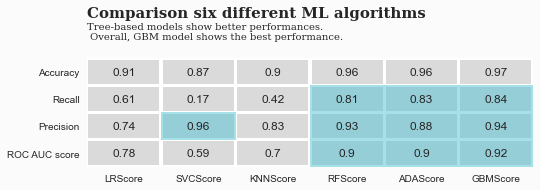

In [14]:
import matplotlib

fig = plt.figure(figsize=(8, 11))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ['#DADADA', '#DADADA']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# change background color
background_color='#fbfbfb'
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)


# overall
#df_models = round(pd.concat([svc_df, dtree_df, rfc_df, tu_rfc_df, log_df, knn_df], axis=1), 3)

sns.heatmap(models_df, cmap=colormap, annot=True, linewidths=2.5, cbar=False, ax=ax0)

ax0.tick_params(axis=u'both', which=u'both', length=0)
ax0.text(0, -1.5, 'Comparison six different ML algorithms', fontfamily='serif', fontsize=15, fontweight='bold')
ax0.text(0, -0.7, 'Tree-based models show better performances.\n Overall, GBM model shows the best performance.',
        fontfamily='serif', fontsize=10)


from matplotlib.patches import Rectangle
rect = ax0.add_patch(Rectangle((3, 1), 3, 3, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))
rect2 = ax0.add_patch(Rectangle((1, 2), 1, 1, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))

plt.show()

As we can see above, tree-based models show better performances. Based on the Recall, Precision, and roc-auc score, I will use gbm model for final pipeline. 

## Pipeline for GBM model

We found gbm model shows the best performance. Also, I found the best hyperparameters by using Optuna in the [HyperparameterTuningForGBM]. (If you want to see more detail, please take a look at the notebook). 


In [15]:
# let's start to load data again
df = pd.read_csv(path/'BankChurners.csv')

In [16]:
# drop unuseful columns 
df.drop(['CLIENTNUM',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis=1, inplace=True)

df.shape

(10127, 20)

In [17]:
# change y value (0,1)
churn_map = {'Existing Customer': 0,
            'Attrited Customer': 1}
df['Attrition_Flag'] = df['Attrition_Flag'].map(churn_map)

# separate into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Attrition_Flag'], axis=1),
    df['Attrition_Flag'],
    test_size=0.2,
    random_state=0
)

X_train.shape, X_test.shape

((8101, 19), (2026, 19))

In [18]:
# this is the best paramter we found 
# in hyperparater tuning notebook

# set the paramters
best_param = {
    'n_estimators': 658,
    'criterion': 'friedman_mse',
    'max_depth': 5,
    'min_samples_split': 0.017209668061883378,
    'max_features': 'sqrt',
    'learning_rate': 0.050497537295197764
}

In [19]:
model_pipe = imbPipeline([
    
    # categorical encoding 
    ("cat_encoding", ce.OrdinalEncoder(
        encoding_method='arbitrary', variables=cat_vars)),
    
    # feature scaling
    ("scale", StandardScaler()),
    
    # oversampling with ADASYN
    ("oversampling", ADASYN(sampling_strategy='auto', random_state=0, n_neighbors=5)),
    
    # classifier
    ("gbm", GradientBoostingClassifier(**best_param))
])

In [20]:
# set up multiple scoring
scoring = {'accuracy': 'accuracy',
           'recall': 'recall_macro',
           'precision': 'precision_macro',
           'roc-auc': 'roc_auc'}

In [21]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
scores = cross_validate(model_pipe, X_train, y_train, scoring=scoring, 
                        cv=cv, n_jobs=-1)

#print("Mean ROC AUC: %.3f" % np.mean(scores))

In [22]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_recall', 'test_precision', 'test_roc-auc'])


In [23]:
# create scores as dataframe
scores_df = pd.DataFrame(pd.Series(scores))

# set column name
scores_df.columns = ['scores']

# create an empty column 
scores_df['GBM_with_best_params'] = np.NaN

# create a column showing the average of scores
for i in range(len(scores_df)):
    scores_df['GBM_with_best_params'][i] = scores_df['scores'][i].mean()
    
# drop unuseful columns
scores_df.drop(['scores'], axis=1, inplace=True)

scores_df = scores_df.T
scores_df.drop(['fit_time', 'score_time'], axis=1, inplace=True)

# change index names in order to combine this with baseline GBM scores
scores_df = scores_df.T
scores_df.index = ['Accuracy', 'Recall', 'Precision', 'ROC AUC score']
scores_df

,GBM_with_best_params
Accuracy,0.971280
Recall,0.944944
Precision,0.949378
ROC AUC score,0.992964


In [24]:
# Combine baseline's GBMscores and new GBM scores
new_df = pd.concat([models_df['GBMScore'], scores_df], axis=1)

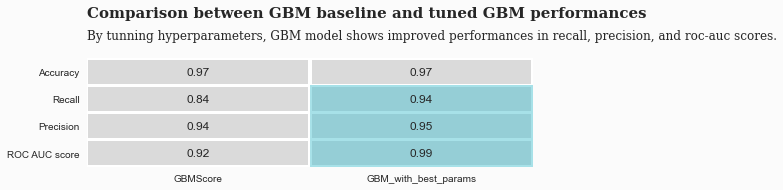

In [25]:
import matplotlib

fig = plt.figure(figsize=(8, 11))
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ['#DADADA', '#DADADA']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# change background color
background_color='#fbfbfb'
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)


# overall

sns.heatmap(new_df, cmap=colormap, annot=True, linewidths=2.5, cbar=False, ax=ax0)

ax0.tick_params(axis=u'both', which=u'both', length=0)
ax0.text(0, -1.5, 'Comparison between GBM baseline and tuned GBM performances', fontfamily='serif', fontsize=15, fontweight='bold')
ax0.text(0, -0.7, 'By tunning hyperparameters, GBM model shows improved performances in recall, precision, and roc-auc scores.',
        fontfamily='serif', fontsize=12)


from matplotlib.patches import Rectangle
rect = ax0.add_patch(Rectangle((1, 1), 3, 3, fill=True,color='#51C4D3', edgecolor='white', lw=0,alpha=0.5))

plt.show()

By tuning hyperparameters, we got the improved final model's performance (0.993 of ROC-AUC score) increased by 7% compared to the baseline (0.916 of ROC-AUC). 

## Conclusion

In this notebook, we compared six different algorithms, and we found Gradient Boosting model showed the best performance. Therefore, we tried to find the best hyperparameters by using Optuna in [HyperparamterTuningForGBM.ipynb]. 

**By using the best hyperparamters, we got an improved GBM model showing 7% increased performance (0.993 of ROC-AUC score) compared to the baseline (0.916 of ROC-AUC).**